In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, PrecisionRecallDisplay
import sklearn.metrics as metrics

In [3]:
# Load the dataset
df = pd.read_csv('Active_Creators_Random_Forest.csv')

# Fill missing values with zeros
df.fillna(0, inplace=True)

# Select columns relevant for identifying new active creators
columns_of_interest = [
    'is_active', 'change_button_link', 'videos_uploaded',
    'save_edit_placeholder', 'publishes', 'change_button_name', 'w_sessions',
    'change_placeholder_title', 'w_watches', 'w_auth_watchers',
    'w_customers', 'w_revenue'
]
df = df[columns_of_interest]

# Count the distribution of the target variable 'is_active'
active_counts = df['is_active'].value_counts()
print(active_counts)

0.0    1026
1.0     112
Name: is_active, dtype: int64


In [4]:
# Prepare the dataset for model training
Y = df['is_active'].values.astype(int)  # Target variable
X = df.drop(['is_active'], axis=1)  # Feature set

# Split dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

# Train RandomForestClassifier
model = RandomForestClassifier(n_estimators=1000, random_state=42, bootstrap=False)
model.fit(X_train, Y_train)

# Evaluate feature importance
feature_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_imp)

# Save the model
joblib.dump(model, 'random_forest_model.pkl')


save_edit_placeholder       0.287891
w_sessions                  0.191195
videos_uploaded             0.151545
w_watches                   0.120576
publishes                   0.103856
w_auth_watchers             0.053547
change_placeholder_title    0.038308
w_revenue                   0.023252
w_customers                 0.015896
change_button_link          0.009067
change_button_name          0.004867
dtype: float64


['random_forest_model.pkl']

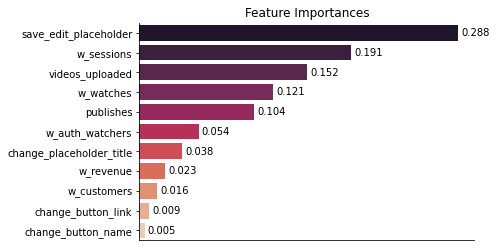

In [5]:
# Create a DataFrame to hold feature names and their importances
features_df = pd.DataFrame({
    'Feature': model.feature_names_in_,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importances in descending order
features_df_sorted = features_df.sort_values(by='Importance', ascending=False)

# Create a bar plot to visualize feature importances
g = sns.barplot(data=features_df_sorted, x='Importance', y='Feature', palette="rocket")
sns.despine()  # Remove the top and right spines
g.set_title('Feature Importances')
g.set(xlabel=None, ylabel=None)  # Remove axis labels
g.set(xticks=[])  # Remove x-axis tick marks

# Annotate bars with the importance values
for container in g.containers:
    g.bar_label(container, fmt='%.3f', padding=3)


In [7]:
# Predict on the test set
prediction_test = model.predict(X_test)

# Calculate and print model performance metrics
accuracy = metrics.accuracy_score(Y_test, prediction_test)
roc_auc = roc_auc_score(Y_test, model.predict_proba(X_test)[:, 1])
conf_matrix = confusion_matrix(Y_test, prediction_test)
class_report = classification_report(Y_test, prediction_test)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Accuracy: 0.9473
ROC AUC Score: 0.9524
Confusion Matrix:
[[495  12]
 [ 18  44]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       507
           1       0.79      0.71      0.75        62

    accuracy                           0.95       569
   macro avg       0.88      0.84      0.86       569
weighted avg       0.95      0.95      0.95       569



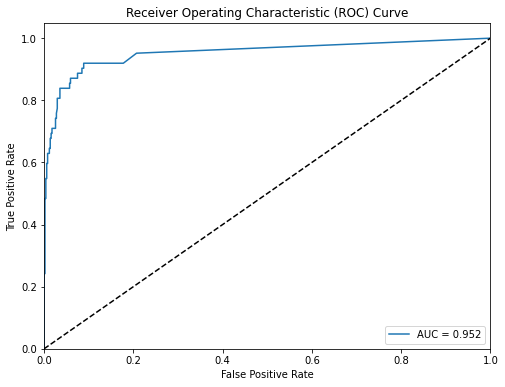

In [8]:
# Calculating the probability scores of the positive class
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculating ROC curve and ROC AUC score
fpr, tpr, _ = metrics.roc_curve(Y_test, y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)

# Creating the ROC curve
plt.figure(figsize=(8, 6))  # Optional: Adjusting the figure size for better readability
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")  # Adding the AUC score to the plot
plt.plot([0, 1], [0, 1], 'k--')  # Adding a diagonal dashed line for reference
plt.xlim([0.0, 1.0])  # Setting X-axis limits
plt.ylim([0.0, 1.05])  # Setting Y-axis limits
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")  # Correcting the location of the legend
plt.show()

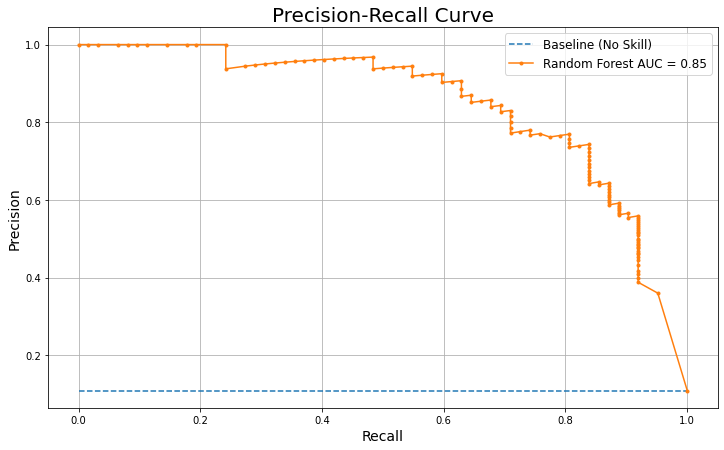

In [11]:
# Importing necessary functions for Precision-Recall curve
from sklearn.metrics import auc, precision_recall_curve

# Calculate probabilities of the positive class
probs_rf = model.predict_proba(X_test)[:, 1]

# Calculate baseline proportion of positive class
baseline_model = sum(Y_test == 1) / len(Y_test)

# Calculate Precision and Recall for the model
precision_rf, recall_rf, _ = precision_recall_curve(Y_test, probs_rf)
auc_rf = auc(recall_rf, precision_rf)  # Calculate AUC of the Precision-Recall curve

# Plotting the Precision-Recall curve
plt.figure(figsize=(12, 7))
plt.plot([0, 1], [baseline_model, baseline_model], linestyle='--', label='Baseline (No Skill)')
plt.plot(recall_rf, precision_rf, marker='.', label=f'Random Forest AUC = {auc_rf:.2f}')

plt.title('Precision-Recall Curve', fontsize=20)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)  # Optionally add a grid for better readability
plt.show()


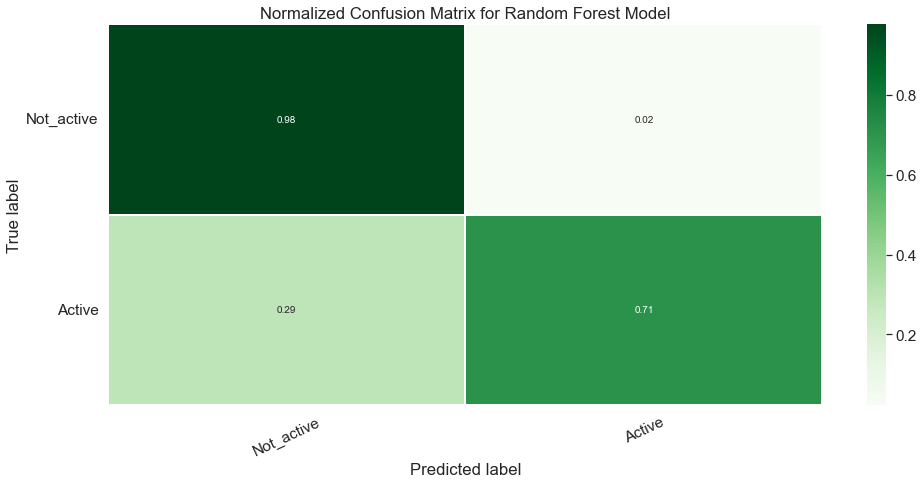

In [12]:
# Convert confusion matrix to percentage format
matrix = confusion_matrix(Y_test, prediction_test)
matrix_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Initialize the plot
plt.figure(figsize=(16, 7))
sns.set(font_scale=1.4)  # Increase font scale for readability

# Create a heatmap for the confusion matrix
sns.heatmap(matrix_normalized, annot=True, annot_kws={'size': 10},
            cmap='Greens', linewidths=0.2, fmt='.2f')

# Define and set the class names on the axes
class_names = ['Not_active', 'Active']
tick_marks = np.arange(len(class_names)) + 0.5

plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks, class_names, rotation=0, va="center")

# Set labels and title for the plot
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Normalized Confusion Matrix for Random Forest Model')

# Display the plot
plt.show()
